<a href="https://colab.research.google.com/github/SulemanDawoodAhmad/ML-Crypto-Currency-Prediction-Project/blob/main/Crypto_Currency_SL_TP_Prediction_Project_Model_Building_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 %%capture

#Installing Tensor Flow Library
!./configure --prefix=/usr
!make
!make install
!pip instal tensorflow
!pip install shap

In [ ]:
#Import Libraries

import os
from numpy import mean
from numpy import std
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns
from tensorflow import keras
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from scipy.sparse.lil import lil_matrix
import shap
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.backend import categorical_crossentropy
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/Colab Notebooks'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


**Importing Datasets**

In [ ]:
train_data=pd.read_excel('train_data_final.xlsx')
train_data=train_data.drop(['Unnamed: 0'], axis=1)
test_data1=pd.read_excel('test_data1_final.xlsx')
test_data1=test_data1.drop(['Unnamed: 0'], axis=1)
test_data2=pd.read_excel('test_data2_final.xlsx')
test_data2=test_data2.drop(['Unnamed: 0'], axis=1)

**XG BOOST-Grid Search**

**Defining Test and Train Set Features and Target Variables**

In [ ]:
# Define X and Y variables to build the ensemble model. 

#Train Data
X_train = train_data.drop(['pair', 'Min_12','P5_12','P10_12','P25_12','Median_12','P75_12','P90_12','P95_12','Max_12','Mean_12','STD_12','sl_tp','sl_tp_r'], axis = 1)
Y_train_cons = train_data['sl_tp']
Y_train_risk = train_data['sl_tp_r']

#Test Data 1
X_test1 = test_data1.drop(['pair', 'Min_12','P5_12','P10_12','P25_12','Median_12','P75_12','P90_12','P95_12','Max_12','Mean_12','STD_12','sl_tp','sl_tp_r'], axis = 1)
Y_test1_cons = test_data1['sl_tp']
Y_test1_risk = test_data1['sl_tp_r']

#Test Data 2
X_test2 = test_data2.drop(['pair', 'Min_12','P5_12','P10_12','P25_12','Median_12','P75_12','P90_12','P95_12','Max_12','Mean_12','STD_12','sl_tp','sl_tp_r'], axis = 1)
Y_test2_cons = test_data2['sl_tp']
Y_test2_risk = test_data2['sl_tp_r']


**Conservative Approach**

**Feature Selection**

In [ ]:
xgb_instance = xgb.XGBClassifier() # nothing inside paranthesis, meaning we are using default parameters, with 100 trees.

model_for_feature_selection = xgb_instance.fit(X_train, Y_train_cons)

In [ ]:
feature_importance = {'Feature':X_train.columns,'Importance':model_for_feature_selection.feature_importances_}
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values("Importance", inplace=True,ascending=False)
feature_importance

,Feature,Importance
33,middleBB,0.340332
32,upperBB,0.084793
14,ema_4h,0.065483
16,ema_12h,0.043686
17,ema_24h,0.030746
28,aroon_down,0.026430
15,ema_8h,0.026279
35,fastk,0.022896
10,wma_24h,0.022277
39,volume_cumulative,0.022246


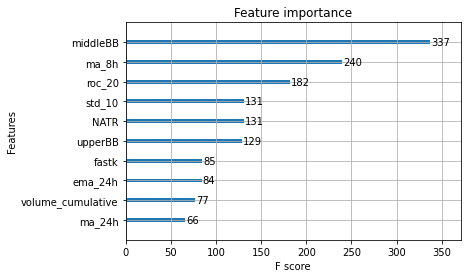

In [ ]:
#Plot the Features

plot_importance(model_for_feature_selection, max_num_features=10)
plt.show()

In [ ]:
final_features = feature_importance["Feature"][feature_importance.Importance > 0.005]

X_train = X_train[final_features]
X_test1 = X_test1[final_features]
X_test2 = X_test2[final_features]

In [ ]:
X_train.mean().to_excel('ab.xlsx')

**Grid Search**

In [ ]:
#AUC is used as performance metric on all samples.

table = pd.DataFrame(columns = ["Num Trees", "Learning Rate", "Tree Depth", "AUC Train", "AUC Test 1", "AUC Test 2"])
learn_rate=np.array([0.01,0.05,0.1])
num_trees=np.array([20,50,80,100])
tree_depth=np.array([5,10])

row = 0
for LR, num_tree, depth in product(range(len(learn_rate)), range(len(num_trees)), range(len(tree_depth))):
    lr=learn_rate[LR]
    n=num_trees[num_tree]
    d=tree_depth[depth]
    xgb_instance = xgb.XGBClassifier(n_estimators=n, learning_rate = lr, max_depth=d)
    model = xgb_instance.fit(X_train, Y_train_cons)

    table.loc[row,"Num Trees"] = n
    table.loc[row,"Learning Rate"] = lr
    table.loc[row,"Tree Depth"] = d
    table.loc[row,"AUC Train"] = roc_auc_score(Y_train_cons, model.predict_proba(X_train), multi_class='ovr', average='weighted')
    table.loc[row,"AUC Test 1"] = roc_auc_score(Y_test1_cons, model.predict_proba(X_test1), multi_class='ovr', average='weighted')
    table.loc[row,"AUC Test 2"] = roc_auc_score(Y_test2_cons, model.predict_proba(X_test2), multi_class='ovr', average='weighted')

    row = row + 1

table

,Num Trees,Learning Rate,Tree Depth,AUC Train,AUC Test 1,AUC Test 2
0,20,0.01,5,0.879478,0.873867,0.850948
1,20,0.01,10,0.91473,0.874992,0.846868
2,50,0.01,5,0.882283,0.876193,0.853936
3,50,0.01,10,0.920402,0.879139,0.854204
4,80,0.01,5,0.883986,0.877579,0.855806
5,80,0.01,10,0.924535,0.880561,0.855595
6,100,0.01,5,0.884901,0.878389,0.856377
7,100,0.01,10,0.926877,0.881377,0.85638
8,20,0.05,5,0.884674,0.878328,0.856525
9,20,0.05,10,0.926579,0.88133,0.855919


**Bias-Variance Tradeoff**

In [ ]:
table['variance']=np.var(table.loc[:,['AUC Train', 'AUC Test 1', 'AUC Test 2']], axis=1)
table

NameError: ignored

In [ ]:
#Export the Results of Grid Search to Excel File

table.to_excel('grid_search_xgboost.xlsx')

**Building Final Model**

In [ ]:
xgb_instance = xgb.XGBClassifier(n_estimators=80, learning_rate = 0.1, max_depth=5)
final_model_c = xgb_instance.fit(X_train, Y_train_cons)

In [ ]:
X_test1.loc[:, 'predict']=final_model_c.predict(X_test1)

In [ ]:
X_test1.to_excel('test_prediction.xlsx')

**SHAP Analysis**

**Getting Shapley Values**

In [ ]:
shap_values = shap.TreeExplainer(final_model_c).shap_values(X_train)

**SHAP Summary Plot**

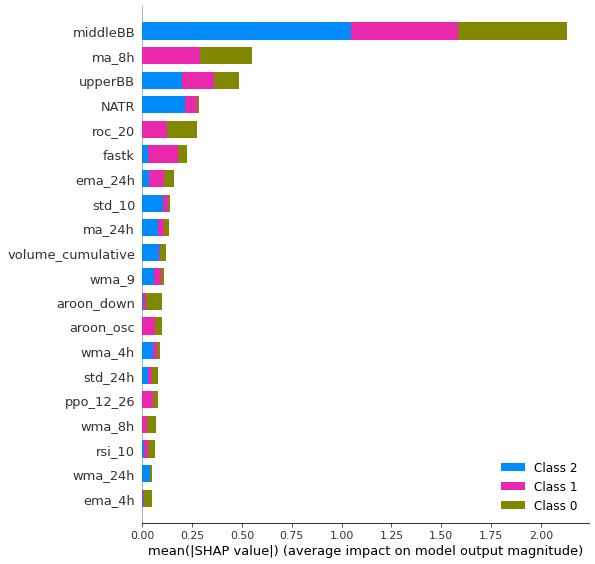

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

**SHAP Dependency Plots**

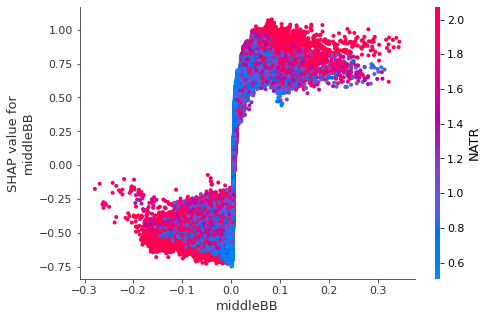

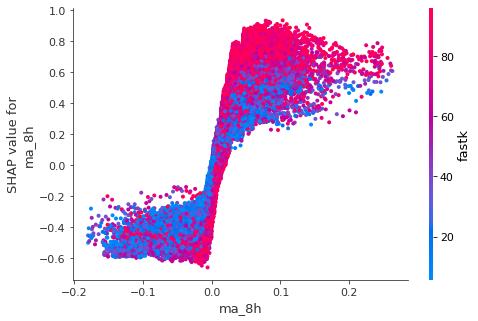

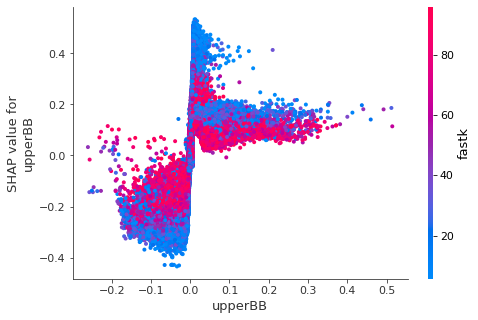

In [ ]:
#Shape Dependency Plots for Top 3 Variables

shap.dependence_plot('middleBB', shap_values[1], X_train)
shap.dependence_plot('ma_8h', shap_values[1], X_train)
shap.dependence_plot('upperBB', shap_values[1], X_train)

**Individual SHAP Value Plot-One Observation**

In [ ]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(final_model_c)
    shap_values_Model = explainerModel.shap_values(X_train)[1]
    p = shap.force_plot(explainerModel.expected_value[1], shap_values_Model[j], X_train.iloc[[j]], link='logit')
    return(p)

shap_plot(1)

**Neural Network**

**Outlier Treatment**

We will not be performing outlier treatment because the outliers in these case might pertain to upward or downward trends or opportunities to make profit. So, it is not appropriate to perform outlier treatment for our modeling exercise. 

**Normalization**

We will use the minmaxscaler() from scikit learn package. 

In [ ]:
#Transforming the Input Variables using the 

trans = MinMaxScaler()
X_train = trans.fit_transform(X_train)
X_test1 = trans.transform(X_test1)
X_test2 = trans.transform(X_test2)

**Neural Networks-Grid Search**

In [ ]:
#Function to Classify the Number of Layers in the Classifier

#Function for Classifier
def createmodel(n_layers, nodes, activation_func):
    model = Sequential()
    for i in range(1, n_layers):
      model.add(Dense(nodes, activation=activation_func))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy', metrics.AUC(multi_label=True)]) #note: metrics could also be 'mse'
    
    return model

#Wrap model into scikit-learn
model =  KerasClassifier(build_fn=createmodel) 

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
activation_funcs = ['sigmoid', 'relu'] 
layers = [5,10]
node = [32,64]
param_grid = dict(n_layers=layers, nodes = node, activation_func = activation_funcs)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='roc_auc_ovr')

In [ ]:
#Convert X-train and Y-train Data to the 
X_train=np.asarray(X_train)
Y_train_cons=np.asarray(Y_train_cons)

In [ ]:
#Run the Grid Search on Train Data
grid_search=grid.fit(X_train,Y_train_cons)

9307/9307 [==============================] - 25s 3ms/step - loss: 0.5383 - accuracy: 0.7787 - auc_91: 0.8436


In [ ]:
#Get the Best Parameters based on Grid Search and the Score on Specified Performance Metric

best_parameters = grid_search.best_params_ 
best_accuracy = grid_search.best_score_

In [ ]:
best_parameters

{'activation_func': 'relu', 'n_layers': 5, 'nodes': 64}

In [ ]:
best_accuracy

0.8273131142931348

In [ ]:
#Mean and Standard Deviation of the Performance Metric

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.822250 (0.042306) with: {'activation_func': 'sigmoid', 'n_layers': 5, 'nodes': 32}
0.818439 (0.061449) with: {'activation_func': 'sigmoid', 'n_layers': 5, 'nodes': 64}
0.812055 (0.037613) with: {'activation_func': 'sigmoid', 'n_layers': 10, 'nodes': 32}
0.572753 (0.133771) with: {'activation_func': 'sigmoid', 'n_layers': 10, 'nodes': 64}
0.825706 (0.087471) with: {'activation_func': 'relu', 'n_layers': 5, 'nodes': 32}
0.827313 (0.090685) with: {'activation_func': 'relu', 'n_layers': 5, 'nodes': 64}
0.820483 (0.087286) with: {'activation_func': 'relu', 'n_layers': 10, 'nodes': 32}
0.817019 (0.090382) with: {'activation_func': 'relu', 'n_layers': 10, 'nodes': 64}


**Building the Final Model with 10-Fold Cross-validation**

In [ ]:
#Building the Classifier and Model

def createmodel():
    model = Sequential()
    for i in range(1, 5):
      model.add(Dense(64, activation='relu'))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy', metrics.AUC(multi_label=True)]) #note: metrics could also be 'mse'
    
    return model

final_model_nn =  KerasClassifier(build_fn=createmodel) 

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
#Performing 10-Fold Cross-validation

final_model_nn_cv= cross_val_score(final_model_nn, X_test2, Y_test2_cons, cv=10, scoring="roc_auc_ovr")

751/751 [==============================] - 3s 3ms/step - loss: 32810053632.0000 - accuracy: 0.4785 - auc_20: 0.4960


In [ ]:
#Model Performance

print('AUC: %.3f (%.3f)' % (mean(final_model_nn_cv), std(final_model_nn_cv)))

AUC: 0.507 (0.021)


In [ ]:
roc_auc_score(Y_test1_cons, final_model_nn_cv(X_test1), multi_class='ovr', average='weighted')

TypeError: ignored